# Session 4 — Paragraph-Level Analysis
## Measure 1: Paragraph Semantic Coherence

In this notebook, you will:
- split your text into paragraphs and sentences
- compute **embedding-based coherence** per paragraph using MiniLM
- compare coherence distributions across two books
- connect this to how RAG systems and LLMs assess chunk quality

We again use Lewis Carroll's *Alice* books as examples. Replace the file
paths with your own author/text for your project.


In [1]:
import re
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

# You may need to install this once in your environment:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

def load_book(filepath: str) -> str:
    """Load and lightly clean a book text (Project Gutenberg style)."""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    # Very simple Project Gutenberg cleaner (adapt to your own corpus)
    if 'CHAPTER I' in text:
        start = text.find('CHAPTER I')
        text = text[start:]
    elif '*** START OF' in text:
        start = text.find('*** START OF')
        text = text[start + 100:]

    if '*** END OF' in text:
        end = text.find('*** END OF')
        text = text[:end]
    elif 'End of Project Gutenberg' in text:
        end = text.find('End of Project Gutenberg')
        text = text[:end]

    return text.strip()

# Load both Alice books (replace with your own paths)
crime_text = load_book('../data/Crime-punishment.txt')
brothers_karamazov_text = load_book('../data/The-Brotherskaramazov.txt')

print(f"Crime and Punishment characters: {len(crime_text):,}")
print(f"The Brothers Karamazov characters: {len(brothers_karamazov_text):,}")

c:\Users\moham\NLP_w4\applied-NLP-week4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Crime and Punishment characters: 1,224,428
The Brothers Karamazov characters: 1,956,237


In [2]:
def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    """Split raw text into paragraphs using blank lines as boundaries.
    Filters out very short paragraphs (e.g. chapter titles)."""
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    raw_paras = re.split(r'\n\s*\n+', text)
    paras = []
    for p in raw_paras:
        cleaned = re.sub(r'\s+', ' ', p).strip()
        if not cleaned:
            continue
        if len(cleaned.split()) < min_words:
            continue
        paras.append(cleaned)
    return paras

def sentence_split(paragraph: str) -> List[str]:
    """Very simple sentence splitter based on punctuation."""
    sentences = re.split(r'[.!?]+\s+', paragraph.strip())
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1:
        a = a.reshape(-1)
    if b.ndim > 1:
        b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)

def paragraph_coherence_embeddings(paragraphs: List[str]) -> Tuple[list, list]:
    """Compute embedding-based coherence for each paragraph.

    Steps:
    - Split each paragraph into sentences
    - Compute MiniLM embeddings for all sentences
    - Compute the centroid (mean embedding) for the paragraph
    - Coherence = average cosine similarity of each sentence
      to the centroid embedding
    """
    scores = []
    lengths = []
    for p in paragraphs:
        sents = sentence_split(p)
        if len(sents) < 2:
            continue
        # Encode all sentences in this paragraph
        sent_embs = model.encode(sents)
        centroid = sent_embs.mean(axis=0)
        sims = [cosine_similarity(e, centroid) for e in sent_embs]
        scores.append(sum(sims) / len(sims))
        lengths.append(len(" ".join(sents).split()))
    return scores, lengths

crime_paras = split_into_paragraphs(crime_text)
brothers_karamazov_paras = split_into_paragraphs(brothers_karamazov_text)

c_scores, c_lengths = paragraph_coherence_embeddings(crime_paras)
b_scores, b_lengths = paragraph_coherence_embeddings(brothers_karamazov_paras)
print(f"Crime and Punishment mean coherence (embeddings): {sum(c_scores)/len(c_scores):.3f}")
print(f"The Brothers Karamazov mean coherence (embeddings): {sum(b_scores)/len(b_scores):.3f}")

Crime and Punishment mean coherence (embeddings): 0.519
The Brothers Karamazov mean coherence (embeddings): 0.688


C:\Users\moham\AppData\Local\Temp\ipykernel_2700\3232387.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


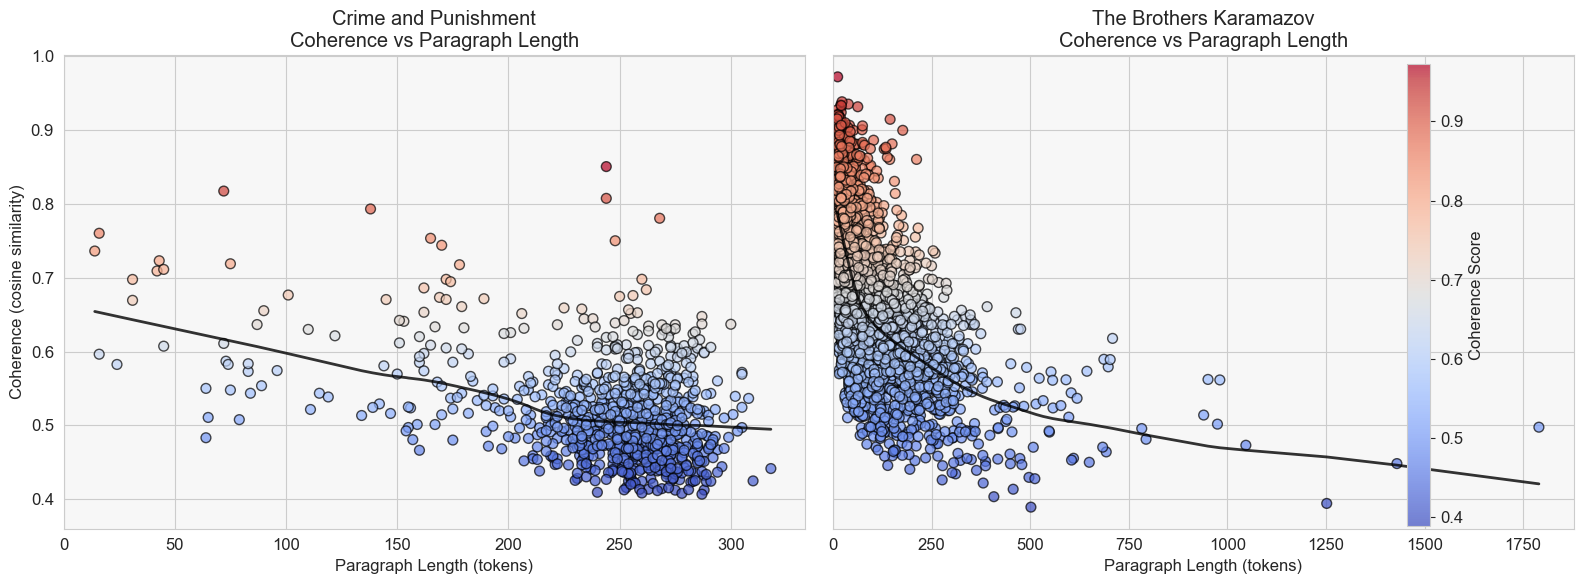

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set modern style
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "figure.figsize": (16, 6),
    "axes.facecolor": "#f7f7f7",
})

fig, axes = plt.subplots(1, 2, sharey=True)

# Color map based on coherence values
cmap = plt.cm.coolwarm

# Plot 1: Crime and Punishment
scatter1 = axes[0].scatter(
    c_lengths, c_scores,
    c=c_scores,
    cmap=cmap,
    alpha=0.7,
    s=50,
    edgecolors="black"
)
sns.regplot(
    x=c_lengths, y=c_scores,
    ax=axes[0],
    scatter=False,
    lowess=True,
    line_kws={"color": "black", "lw": 2, "alpha": 0.8}
)
axes[0].set_title("Crime and Punishment\nCoherence vs Paragraph Length")
axes[0].set_xlabel("Paragraph Length (tokens)")
axes[0].set_ylabel("Coherence (cosine similarity)")
axes[0].set_xlim(left=0)

# Plot 2: The Brothers Karamazov
scatter2 = axes[1].scatter(
    b_lengths, b_scores,
    c=b_scores,
    cmap=cmap,
    alpha=0.7,
    s=50,
    edgecolors="black"
)
sns.regplot(
    x=b_lengths, y=b_scores,
    ax=axes[1],
    scatter=False,
    lowess=True,
    line_kws={"color": "black", "lw": 2, "alpha": 0.8}
)
axes[1].set_title("The Brothers Karamazov\nCoherence vs Paragraph Length")
axes[1].set_xlabel("Paragraph Length (tokens)")
axes[1].set_xlim(left=0)

# Shared colorbar
cbar = fig.colorbar(scatter2, ax=axes, orientation="vertical", fraction=0.02, pad=0.03)
cbar.set_label("Coherence Score")

plt.tight_layout()
plt.show()



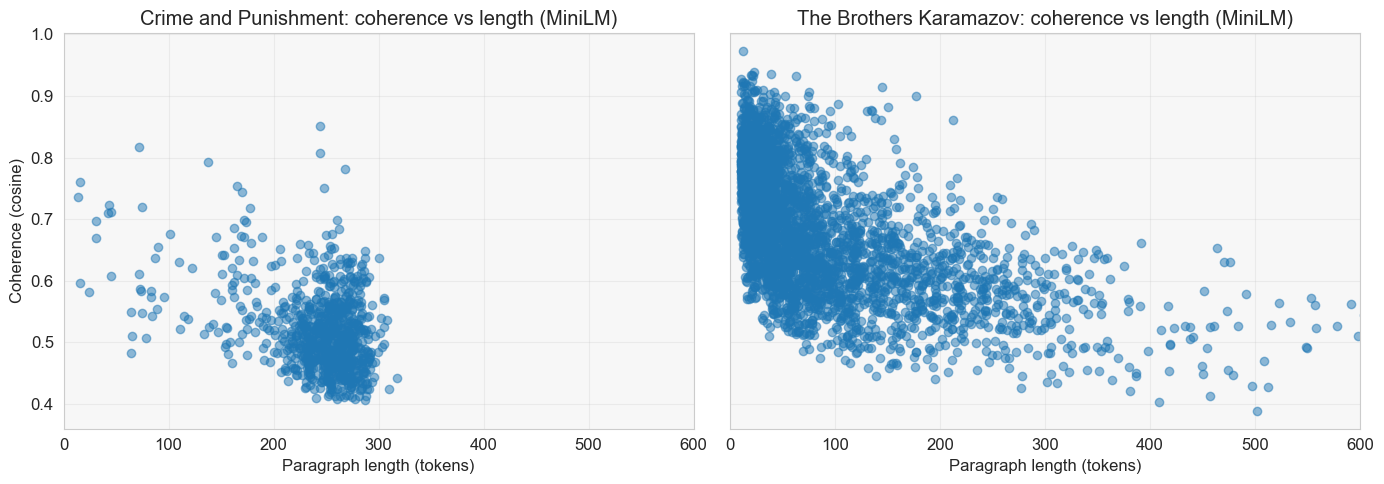

In [4]:
# Visualize coherence vs paragraph length
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].scatter(c_lengths, c_scores, alpha=0.5)
axes[0].set_title("Crime and Punishment: coherence vs length (MiniLM)")
axes[0].set_xlabel("Paragraph length (tokens)")
axes[0].set_ylabel("Coherence (cosine)")
axes[0].set_xlim(0, 600)
axes[0].grid(True, alpha=0.3)

axes[1].scatter(b_lengths, b_scores, alpha=0.5)
axes[1].set_title("The Brothers Karamazov: coherence vs length (MiniLM)")
axes[1].set_xlabel("Paragraph length (tokens)")
axes[1].set_xlim(0, 600)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


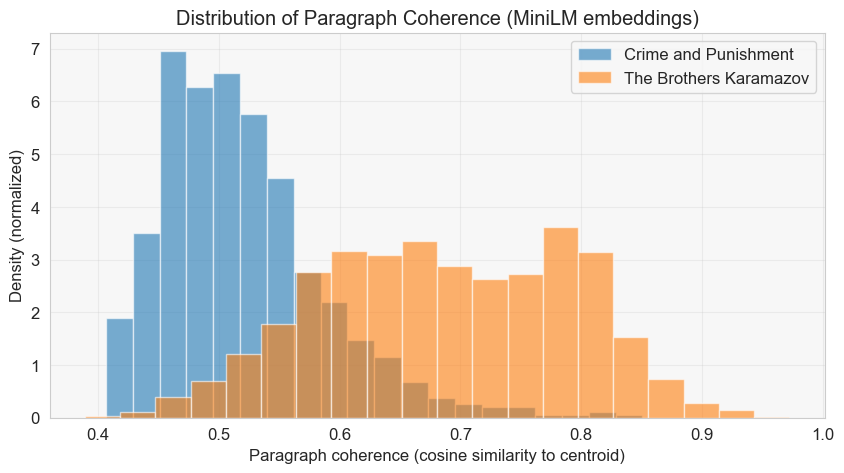

In [5]:
# Compare distributions with histograms
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(c_scores, bins=20, alpha=0.6, label='Crime and Punishment', density=True)
ax.hist(b_scores, bins=20, alpha=0.6, label='The Brothers Karamazov', density=True)
ax.set_xlabel('Paragraph coherence (cosine similarity to centroid)')
ax.set_ylabel('Density (normalized)')
ax.set_title('Distribution of Paragraph Coherence (MiniLM embeddings)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


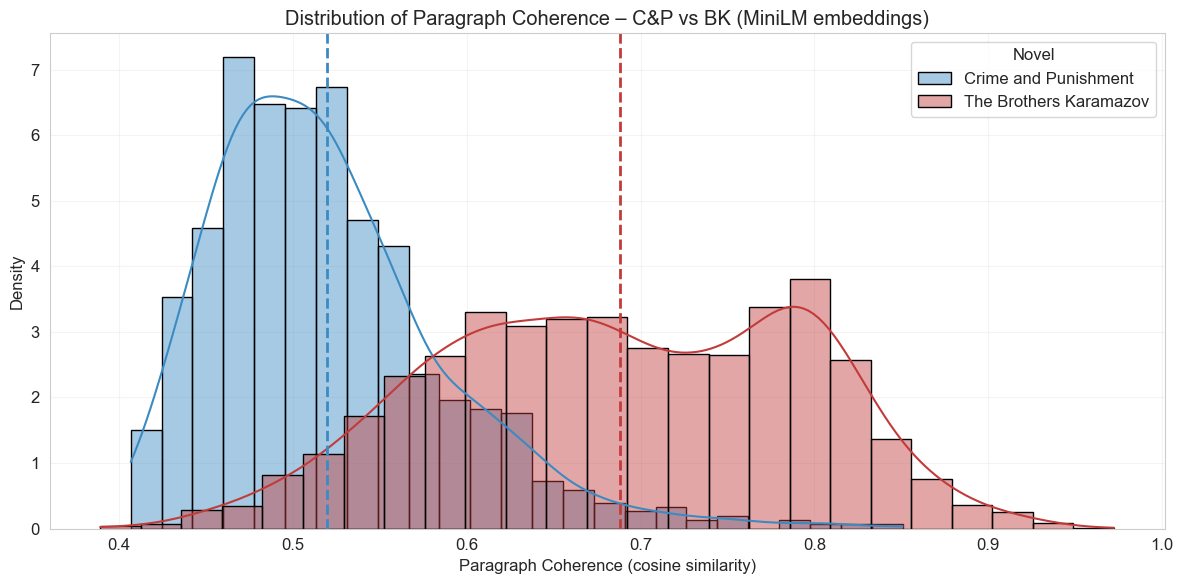

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 6))

# Better color palette
c_color = "#3b8bc2"  # blue-ish
b_color = "#c23b3b"  # red-ish

# Crime and Punishment distribution
sns.histplot(
    c_scores, bins=25, kde=True, stat='density',
    color=c_color, alpha=0.45, edgecolor="black",
    ax=ax, label="Crime and Punishment"
)

# Brothers Karamazov distribution
sns.histplot(
    b_scores, bins=25, kde=True, stat='density',
    color=b_color, alpha=0.45, edgecolor="black",
    ax=ax, label="The Brothers Karamazov"
)

# Add vertical lines for means
ax.axvline(np.mean(c_scores), color=c_color, linestyle="--", linewidth=2)
ax.axvline(np.mean(b_scores), color=b_color, linestyle="--", linewidth=2)

ax.set_xlabel("Paragraph Coherence (cosine similarity)")
ax.set_ylabel("Density")
ax.set_title("Distribution of Paragraph Coherence – C&P vs BK (MiniLM embeddings)")
ax.legend(title="Novel")
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()


In [42]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import re


In [43]:
import json

def load_character_aliases(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    strong_aliases = {}
    weak_aliases = {}
    genders = {}

    for char, entry in data.items():
        strong_aliases[char] = []
        weak_aliases[char] = []
        genders[char] = entry["gender"]

        for alias in entry["aliases"]:
            # allow both string and {"text": ..., "tier": ...}
            if isinstance(alias, str):
                text = alias
                tier = 1
            else:
                text = alias["text"]
                tier = alias.get("tier", 1)

            text = text.lower()  # match your para_lower

            if tier in (1, 2):
                strong_aliases[char].append(text)
            else:  # tier 3+
                weak_aliases[char].append(text)

    return strong_aliases, weak_aliases, genders

STRONG_ALIASES, WEAK_ALIASES, CHARACTER_GENDER = load_character_aliases("Crime_punishment.json")


In [44]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
def character_embedding(character_name: str) -> np.ndarray:
    """Get the embedding for a character's description."""
    description = CHARACTERS.get(character_name, "A fictional character.")
    emb = model.encode([description])[0]
    return emb

In [45]:
def paragraph_coherence(paragraph, model):
    sentences = re.split(r'(?<=[.!?])\s+', paragraph.strip())
    if len(sentences) < 2:
        return None  # too short to compute coherence
    embeddings = model.encode(sentences)
    centroid = np.mean(embeddings, axis=0)
    similarities = cosine_similarity([centroid], embeddings)[0]
    return np.mean(similarities)
def paragraph_coherence_embeddings(paragraphs: List[str]) -> Tuple[list, list]:
    """Compute embedding-based coherence for each paragraph.

    Steps:
    - Split each paragraph into sentences
    - Compute MiniLM embeddings for all sentences
    - Compute the centroid (mean embedding) for the paragraph
    - Coherence = average cosine similarity of each sentence
      to the centroid embedding
    """
    scores = []
    lengths = []
    for p in paragraphs:
        sents = sentence_split(p)
        if len(sents) < 2:
            continue
        # Encode all sentences in this paragraph
        sent_embs = model.encode(sents)
        centroid = sent_embs.mean(axis=0)
        sims = [cosine_similarity(e, centroid) for e in sent_embs]
        scores.append(sum(sims) / len(sims))
        lengths.append(len(" ".join(sents).split()))
    return scores, lengths

In [46]:
def extract_character_paragraphs(text, strong_dict, weak_dict, window=3, min_words=5):
    character_paragraphs = {char: [] for char in strong_dict}
    paragraphs = text.split('\n\n')

    last_strong_seen = {char: -1000 for char in strong_dict}

    for idx, para in enumerate(paragraphs):
        if len(para.split()) < min_words:
            continue

        para_lower = para.lower()

        strong_matched_chars = set()

        # Strong alias match
        for char, aliases in strong_dict.items():
            for alias in aliases:
                if re.search(rf'\b{re.escape(alias)}\b', para_lower):
                    character_paragraphs[char].append(para)
                    last_strong_seen[char] = idx
                    strong_matched_chars.add(char)
                    break

        # Weak alias match
        for char, aliases in weak_dict.items():
            if char in strong_matched_chars:
                continue
            for alias in aliases:
                if re.search(rf'\b{re.escape(alias)}\b', para_lower):
                    if idx - last_strong_seen[char] <= window:
                        character_paragraphs[char].append(para)
                    break

    return character_paragraphs


In [47]:
def compute_character_coherence(character_paragraphs, model):
    coherence_scores = {}
    for char, paras in character_paragraphs.items():
        scores = [paragraph_coherence(p, model) for p in paras]
        scores = [s for s in scores if s is not None]
        if scores:
            coherence_scores[char] = {
                'mean': np.mean(scores),
                'count': len(scores),
                'all_scores': scores
            }
    return coherence_scores
#character_paragraphs = extract_character_paragraphs(crime_text, CHARACTERS)
#character_coherence = compute_character_coherence(character_paragraphs, model)

In [48]:
# Load text
with open("../data/Crime-punishment.txt", "r", encoding="utf-8") as f:
    text = f.read()

# Extract and analyze with tiered aliases
character_paragraphs = extract_character_paragraphs(
    text,
    STRONG_ALIASES,
    WEAK_ALIASES,
    window=3,      # you can try 2–5
    min_words=5    # ignore tiny paragraphs
)

char_coherence = compute_character_coherence(character_paragraphs, model)

for char, stats in char_coherence.items():
    print(f"{char}: mean={stats['mean']:.3f} from {stats['count']} paragraphs")


Rodion_Raskolnikov: mean=0.528 from 516 paragraphs
Sonia_Marmeladov: mean=0.530 from 181 paragraphs
Avdotya_Raskolnikov: mean=0.530 from 184 paragraphs
Arkady_Svidrigailov: mean=0.541 from 9 paragraphs
Dmitri_Razumikhin: mean=0.531 from 30 paragraphs
Pyotr_Luzhin: mean=0.526 from 78 paragraphs
Porfiry_Petrovich: mean=0.522 from 95 paragraphs
Semyon_Marmeladov: mean=0.541 from 31 paragraphs
Katerina_Ivanovna: mean=0.552 from 106 paragraphs
Alyona_Ivanovna: mean=0.552 from 13 paragraphs
Lizaveta_Ivanovna: mean=0.539 from 34 paragraphs
Pulcheria_Alexandrovna: mean=0.542 from 75 paragraphs
Zossimov: mean=0.533 from 56 paragraphs
Alexander_Zametov: mean=0.504 from 43 paragraphs


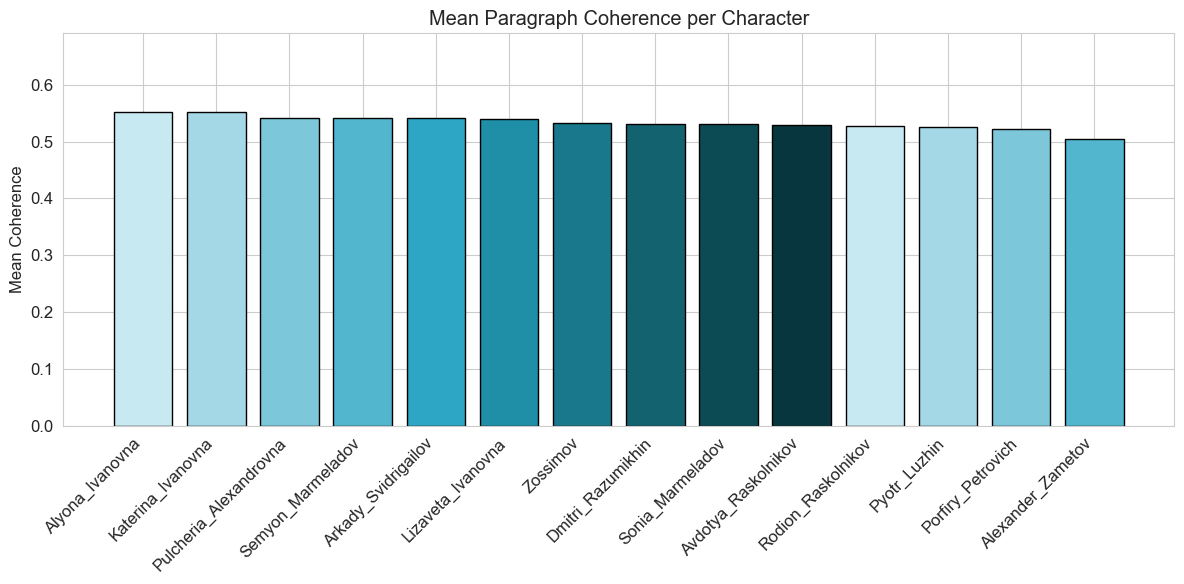

In [49]:
import matplotlib.pyplot as plt

sorted_data = sorted(char_coherence.items(), key=lambda x: x[1]['mean'], reverse=True)
chars = [item[0] for item in sorted_data]
means = [item[1]['mean'] for item in sorted_data]
plt.figure(figsize=(12, 6))
colors = [
    "#c7e9f1",  # very light aqua
    "#a5d8e6",  # soft aqua
    "#7cc7da",  # aqua teal
    "#52b6cf",  # medium teal
    "#2ca6c4",  # teal
    "#1f8fa8",  # deep teal
    "#19788c",  # dark teal-blue
    "#136270",  # deeper teal
    "#0d4b54",  # slate teal
    "#08363e"   # dark slate
]
plt.ylim(0, max(means) * 1.25)

plt.bar(chars, means, color=colors[:len(chars)], edgecolor='black', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.title("Mean Paragraph Coherence per Character")
plt.ylabel("Mean Coherence")
plt.tight_layout()
plt.show()


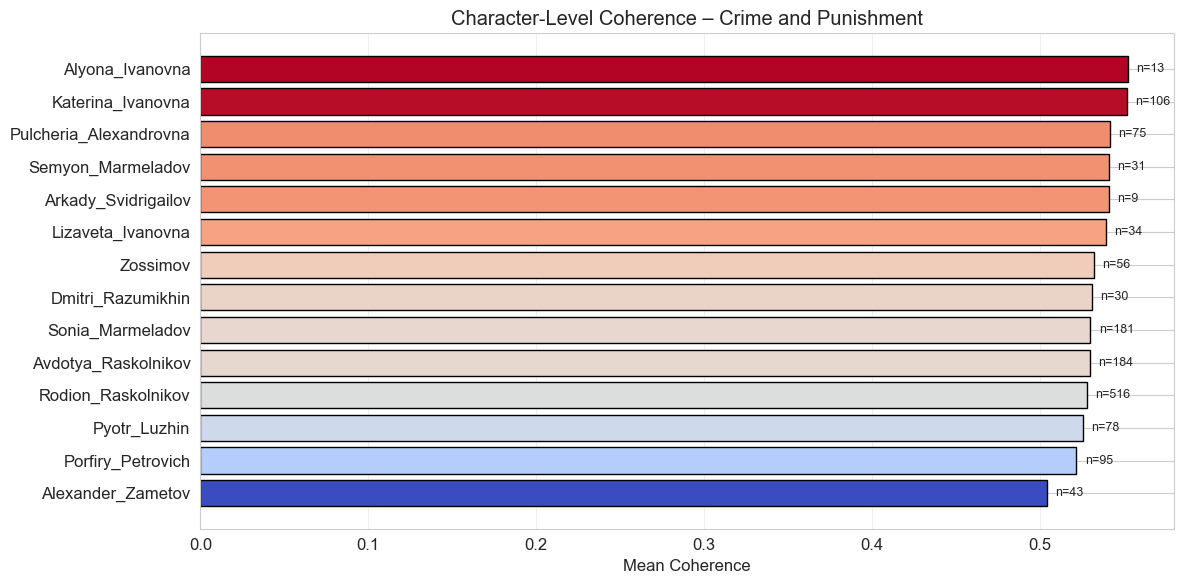

In [50]:

sns.set_style("whitegrid")

# Sort by mean descending
sorted_data = sorted(char_coherence.items(), key=lambda x: x[1]['mean'], reverse=True)
chars = [item[0] for item in sorted_data]
means = [item[1]['mean'] for item in sorted_data]
counts = [item[1]['count'] for item in sorted_data]

# Normalize means for colormap
norm_means = (np.array(means) - min(means)) / (max(means) - min(means))

plt.figure(figsize=(12, 6))
bars = plt.barh(
    chars, means,
    color=plt.cm.coolwarm(norm_means),
    edgecolor="black"
)

# Add count labels at the right edges
for i, count in enumerate(counts):
    plt.text(
        means[i] + 0.005,
        i,
        f"n={count}",
        va="center",
        fontsize=9
    )

plt.xlabel("Mean Coherence")
plt.title("Character-Level Coherence – Crime and Punishment")
plt.gca().invert_yaxis()  # Highest at top
plt.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()


In [54]:
import json

def load_character_aliases(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    strong_aliases = {}
    weak_aliases = {}
    genders = {}

    for char, entry in data.items():
        strong_aliases[char] = []
        weak_aliases[char] = []
        genders[char] = entry["gender"]

        for alias in entry["aliases"]:
            # Allow both string aliases and dicts with tier
            if isinstance(alias, str):
                text = alias.lower()
                tier = 1
            else:
                text = alias["text"].lower()
                tier = alias.get("tier", 1)

            if tier in (1, 2):
                strong_aliases[char].append(text)
            else:  # tier 3
                weak_aliases[char].append(text)

    return strong_aliases, weak_aliases, genders


STRONG_ALIASES, WEAK_ALIASES, CHARACTER_GENDER = load_character_aliases("The_brothers.json")


In [55]:
import re

def extract_character_paragraphs(text, strong_dict, weak_dict, window=3, min_words=5):
    character_paragraphs = {char: [] for char in strong_dict}
    paragraphs = text.split('\n\n')
    last_strong_seen = {char: -1000 for char in strong_dict}

    for idx, para in enumerate(paragraphs):
        if len(para.split()) < min_words:
            continue

        para_lower = para.lower()
        strong_matched = set()

        # Strong matches
        for char, aliases in strong_dict.items():
            for alias in aliases:
                if re.search(rf"\b{re.escape(alias)}\b", para_lower):
                    character_paragraphs[char].append(para)
                    last_strong_seen[char] = idx
                    strong_matched.add(char)
                    break

        # Weak matches (only if strong seen nearby)
        for char, aliases in weak_dict.items():
            if char in strong_matched:
                continue
            for alias in aliases:
                if re.search(rf"\b{re.escape(alias)}\b", para_lower):
                    if idx - last_strong_seen[char] <= window:
                        character_paragraphs[char].append(para)
                    break

    return character_paragraphs


In [56]:
def compute_character_coherence(character_paragraphs, model):
    coherence_scores = {}
    for char, paras in character_paragraphs.items():
        scores = [paragraph_coherence(p, model) for p in paras]
        scores = [s for s in scores if s is not None]
        if scores:
            coherence_scores[char] = {
                'mean': np.mean(scores),
                'count': len(scores)
            }
    return coherence_scores


In [57]:
# Load text
with open("../data/The-Brotherskaramazov.txt", "r", encoding="utf-8") as f:
    bk_text = f.read()

# Extract paragraphs
bk_paragraphs = extract_character_paragraphs(
    bk_text,
    STRONG_ALIASES,
    WEAK_ALIASES,
    window=3,
    min_words=5
)

# Compute coherence
bk_char_coherence = compute_character_coherence(bk_paragraphs, model)

for char, stats in bk_char_coherence.items():
    print(f"{char}: mean={stats['mean']:.3f} from {stats['count']} paragraphs")


Alexei_Karamazov: mean=0.662 from 763 paragraphs
Dmitri_Karamazov: mean=0.676 from 783 paragraphs
Ivan_Karamazov: mean=0.667 from 407 paragraphs
Fyodor_Pavlovich_Karamazov: mean=0.656 from 210 paragraphs
Pavel_Smerdyakov: mean=0.668 from 207 paragraphs
Agrafena_Svetlov: mean=0.664 from 273 paragraphs
Katerina_Ivanovna: mean=0.642 from 189 paragraphs
Father_Zosima: mean=0.643 from 97 paragraphs
Lise_Khokhlakov: mean=0.662 from 99 paragraphs
Mikhail_Rakitin: mean=0.654 from 128 paragraphs
Nikolai_Snegiryov: mean=0.702 from 25 paragraphs


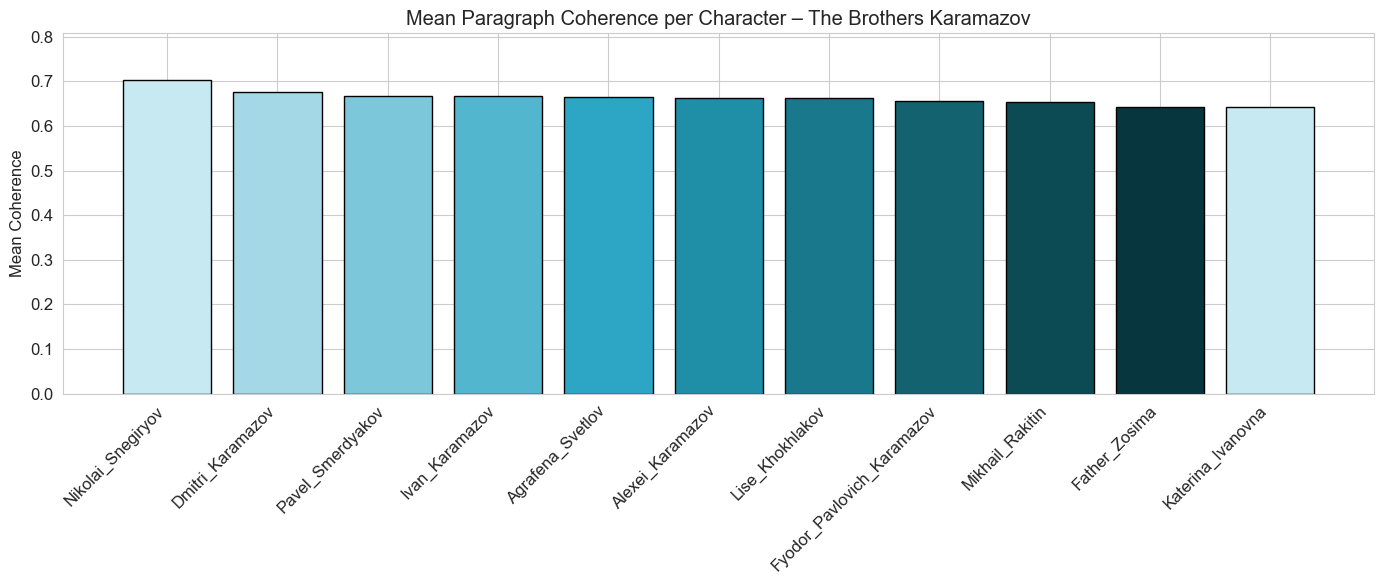

In [58]:
# Sort characters by coherence score (descending)
sorted_data = sorted(bk_char_coherence.items(), key=lambda x: x[1]['mean'], reverse=True)
chars = [item[0] for item in sorted_data]
means = [item[1]['mean'] for item in sorted_data]

plt.figure(figsize=(14, 6))

# Professional blue-green palette
colors = [
    "#c7e9f1",  # very light aqua
    "#a5d8e6",  # soft aqua
    "#7cc7da",  # aqua teal
    "#52b6cf",  # medium teal
    "#2ca6c4",  # teal
    "#1f8fa8",  # deep teal
    "#19788c",  # dark teal-blue
    "#136270",  # deeper teal
    "#0d4b54",  # slate teal
    "#08363e"   # dark slate
]

# Match color list length to number of characters
colors = (colors * (len(chars) // len(colors) + 1))[:len(chars)]

# Increase Y-axis range (more precision later)
plt.ylim(0, max(means) * 1.15)

plt.bar(chars, means, color=colors, edgecolor='black', linewidth=1)

plt.xticks(rotation=45, ha='right')
plt.title("Mean Paragraph Coherence per Character – The Brothers Karamazov")
plt.ylabel("Mean Coherence")

plt.tight_layout()
plt.show()


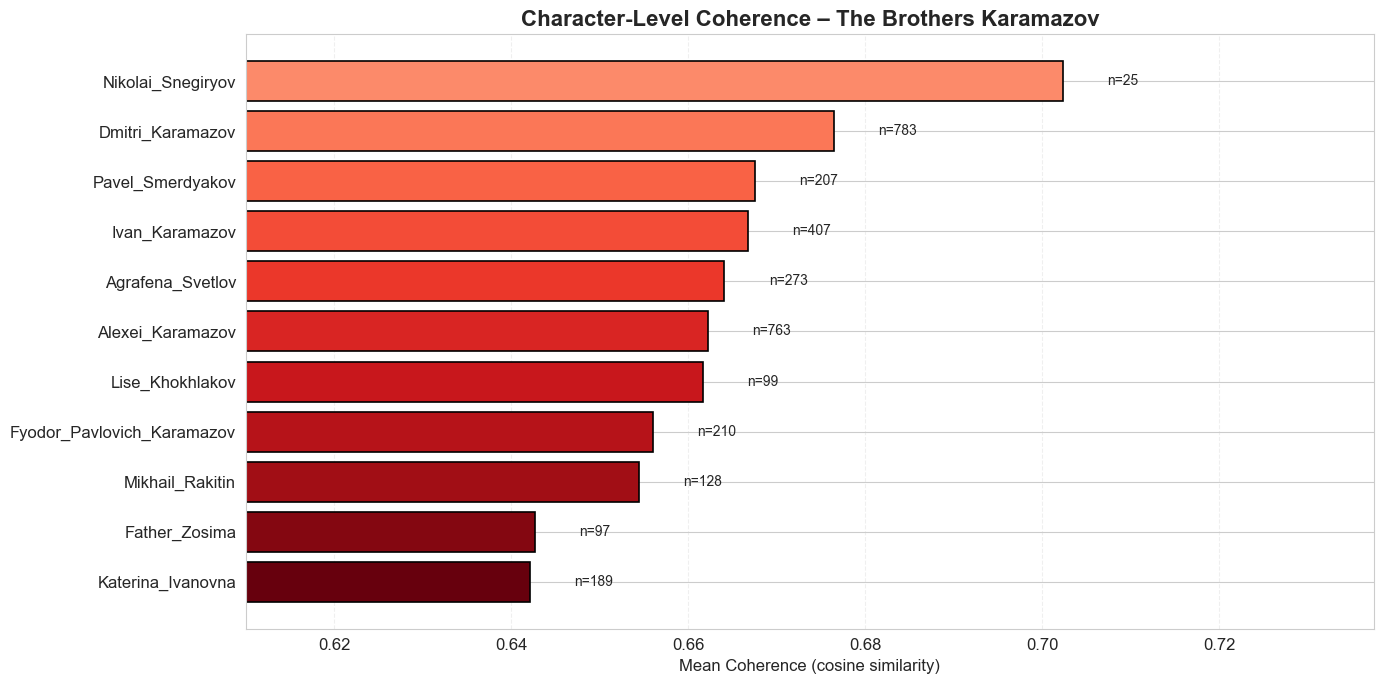

In [59]:


# Sort by coherence score (desc)
sorted_data = sorted(bk_char_coherence.items(), key=lambda x: x[1]['mean'], reverse=True)
chars = [item[0] for item in sorted_data]
means = [item[1]['mean'] for item in sorted_data]
counts = [item[1]['count'] for item in sorted_data]

# Horizontal layout
fig, ax = plt.subplots(figsize=(14, 7))

# Colormap gradient (reversed so top = darkest)
cmap = plt.cm.Reds
colors = cmap(np.linspace(0.4, 1, len(chars)))

bars = ax.barh(chars, means, color=colors, edgecolor='black', linewidth=1.2)

# Add counts at the end of each bar
for bar, n in zip(bars, counts):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
            f"n={n}", va='center', fontsize=10)

# Title + labels
ax.set_xlabel("Mean Coherence (cosine similarity)")
ax.set_title("Character-Level Coherence – The Brothers Karamazov", fontsize=16, weight="bold")

# Flip so highest score is at top
ax.invert_yaxis()

# Better x-axis limits
ax.set_xlim(min(means)*0.95, max(means)*1.05)

# Grid for readability
ax.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Create a directory for the images
output_dir = "presentation_images"
os.makedirs(output_dir, exist_ok=True)
print(f"Saving images to: {os.path.abspath(output_dir)}/")

# Set style
sns.set_style("whitegrid")

# ---------------------------------------------------------
# Graph 1: Scatter Plots (Coherence vs Length)
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Crime & Punishment
axes[0].scatter(c_lengths, c_scores, alpha=0.5, color="#3b8bc2")
axes[0].set_title("Crime and Punishment: Coherence vs Length")
axes[0].set_xlabel("Paragraph length (tokens)")
axes[0].set_ylabel("Coherence (cosine)")
axes[0].set_xlim(0, 600)

# Brothers Karamazov
axes[1].scatter(b_lengths, b_scores, alpha=0.5, color="#c23b3b")
axes[1].set_title("The Brothers Karamazov: Coherence vs Length")
axes[1].set_xlabel("Paragraph length (tokens)")
axes[1].set_xlim(0, 600)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "1_scatter_length_vs_coherence.png"), dpi=300, bbox_inches='tight')
plt.close()
print("Saved Graph 1.")

# ---------------------------------------------------------
# Graph 2: Histogram (Distribution Comparison)
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))
c_color = "#3b8bc2"
b_color = "#c23b3b"

sns.histplot(c_scores, bins=25, kde=True, stat='density', color=c_color, alpha=0.45, label="Crime and Punishment")
sns.histplot(b_scores, bins=25, kde=True, stat='density', color=b_color, alpha=0.45, label="The Brothers Karamazov")

# Vertical means
plt.axvline(np.mean(c_scores), color=c_color, linestyle="--", linewidth=2)
plt.axvline(np.mean(b_scores), color=b_color, linestyle="--", linewidth=2)

plt.xlabel("Paragraph Coherence (cosine similarity)")
plt.ylabel("Density")
plt.title("Distribution of Paragraph Coherence")
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "2_histogram_distribution.png"), dpi=300, bbox_inches='tight')
plt.close()
print("Saved Graph 2.")

# ---------------------------------------------------------
# Graph 3: Character Coherence (Crime & Punishment)
# ---------------------------------------------------------
sorted_cp = sorted(char_coherence.items(), key=lambda x: x[1]['mean'], reverse=True)
chars_cp = [item[0] for item in sorted_cp]
means_cp = [item[1]['mean'] for item in sorted_cp]
counts_cp = [item[1]['count'] for item in sorted_cp]

# Normalize for color map
norm_means_cp = (np.array(means_cp) - min(means_cp)) / (max(means_cp) - min(means_cp))

plt.figure(figsize=(12, 6))
bars = plt.barh(chars_cp, means_cp, color=plt.cm.coolwarm(norm_means_cp), edgecolor="black")

for i, count in enumerate(counts_cp):
    plt.text(means_cp[i] + 0.005, i, f"n={count}", va="center", fontsize=9)

plt.xlabel("Mean Coherence")
plt.title("Character Semantic Stability: Crime and Punishment")
plt.gca().invert_yaxis()
plt.xlim(0, max(means_cp) * 1.15)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "3_bar_crime_punishment.png"), dpi=300, bbox_inches='tight')
plt.close()
print("Saved Graph 3.")

# ---------------------------------------------------------
# Graph 4: Character Coherence (Brothers Karamazov)
# ---------------------------------------------------------
sorted_bk = sorted(bk_char_coherence.items(), key=lambda x: x[1]['mean'], reverse=True)
chars_bk = [item[0] for item in sorted_bk]
means_bk = [item[1]['mean'] for item in sorted_bk]
counts_bk = [item[1]['count'] for item in sorted_bk]

# Blue-Green Palette
colors_bk = ["#c7e9f1", "#a5d8e6", "#7cc7da", "#52b6cf", "#2ca6c4", "#1f8fa8", "#19788c", "#136270", "#0d4b54", "#08363e"]
colors_bk = (colors_bk * (len(chars_bk) // len(colors_bk) + 1))[:len(chars_bk)]

plt.figure(figsize=(12, 6))
bars = plt.barh(chars_bk, means_bk, color=colors_bk, edgecolor="black")

for bar, n in zip(bars, counts_bk):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f"n={n}", va='center', fontsize=10)

plt.xlabel("Mean Coherence")
plt.title("Character Semantic Stability: The Brothers Karamazov")
plt.gca().invert_yaxis()
plt.xlim(min(means_bk)*0.9, max(means_bk)*1.1)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "4_bar_brothers_karamazov.png"), dpi=300, bbox_inches='tight')
plt.close()
print("Saved Graph 4.")
print("Done! All images are in the 'presentation_images' folder.")

Saving images to: c:\Users\moham\NLP_w4\applied-NLP-week4\notebooks\presentation_images/
Saved Graph 1.
Saved Graph 2.
Saved Graph 3.
Saved Graph 4.
Done! All images are in the 'presentation_images' folder.


## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.